In [1]:
%load_ext autoreload
%autoreload 2

import multiprocessing as mp
import torch
import wandb_util.wandb_util as wbu
from scripts.wandb_experiments.comparison_exp import multidim_sweep_exp

torch.set_grad_enabled(False)
mp.set_start_method("spawn", force=True)

In [2]:
from scripts.wandb_experiments.comparison_exp import MultiDimSweepConfig
from scripts.wandb_runs.run_generative_rendering import RunGenerativeRenderingConfig
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.pipelines.pipeline_utils import ModelConfig
from omegaconf import OmegaConf

decoder_paths = [
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

base_config = RunGenerativeRenderingConfig(
    prompt="Deadpool, Blank Background",
    animation_tag="catwalk_180_20:latest",
    generative_rendering=GenerativeRenderingConfig(
        module_paths=decoder_paths,
        attend_to_self_kv=True
    ),
    model=ModelConfig(),
    seed=0,
)
print(base_config)

num_keyframes = [1, 3, 5, 10]
kf_seeds = [0, 1, 2, 3]

override_dims = [
    [{"generative_rendering.num_keyframes": n} for n in num_keyframes],
    [{"kf_seed": i} for i in kf_seeds],
]

override_dim_labels = [num_keyframes, kf_seeds]

sweep_config = MultiDimSweepConfig(
    base_config=OmegaConf.create(base_config),
    override_dims=override_dims,
    override_dim_labels=override_dim_labels,
)
sweep_config = OmegaConf.create(sweep_config)

RunGenerativeRenderingConfig(prompt='Deadpool, Blank Background', animation_tag='catwalk_180_20:latest', generative_rendering=GenerativeRenderingConfig(module_paths=['mid_block.attentions.0.transformer_blocks.0.attn1', 'up_blocks.1.attentions.0.transformer_blocks.0.attn1', 'up_blocks.1.attentions.1.transformer_blocks.0.attn1', 'up_blocks.1.attentions.2.transformer_blocks.0.attn1', 'up_blocks.2.attentions.0.transformer_blocks.0.attn1', 'up_blocks.2.attentions.1.transformer_blocks.0.attn1', 'up_blocks.2.attentions.2.transformer_blocks.0.attn1', 'up_blocks.3.attentions.0.transformer_blocks.0.attn1', 'up_blocks.3.attentions.1.transformer_blocks.0.attn1', 'up_blocks.3.attentions.2.transformer_blocks.0.attn1'], do_pre_attn_injection=True, do_post_attn_injection=True, feature_blend_alpha=0.8, attend_to_self_kv=True, mean_features_weight=0.5, chunk_size=5, num_inference_steps=15, guidance_scale=7.5, controlnet_conditioning_scale=1.0, num_keyframes=3, kf_indices=None), model=ModelConfig(sd_repo

In [3]:
wbu.sync_experiment(multidim_sweep_exp, sweep_config, "180_kf_comparison_deadpool")

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/180_kf_comparison_deadpool/workspace

Would execute 17 new runs:
- o_0
- o_1
- o_2
- o_3
- o_4
- o_5
- o_6
- o_7
- o_8
- o_9
- o_10
- o_11
- o_12
- o_13
- o_14
- o_15
- exp

Would delete 17 outdated runs:
- o_1                            (rpsa0be7)
- o_13                           (pgj3u5l1)
- o_10                           (hurlmv4i)
- o_1                            (28gx53w9)
- o_2                            (4dkoo73g)
- o_14                           (klnfh7j6)
- o_15                           (omy2pkyk)
- o_9                            (ig3whtqt)
- o_0                            (fji75yhe)
- o_11                           (yojq3fyy)
- o_3                            (l70y4ffa)
- o_5                            (rkrwm0eo)
- o_6                            (r558t54w)
- o_7                            (5zih4bkr)
- o_2                            (hvjyqbs7)
- exp                            (g7bsr5vk)
- o_3                      

In [4]:
from text3d2video.util import group_into_array

exp_name = "180_kf_comparison_deadpool"
runs = wbu.get_logged_runs(exp_name)

def n_keyframes_key(run):
    config: RunGenerativeRenderingConfig = OmegaConf.create(run.config)
    return config.generative_rendering.num_keyframes

def kf_seed_key(run):
    config: RunGenerativeRenderingConfig = OmegaConf.create(run.config)
    return config.kf_seed


runs_grouped, labels = group_into_array(runs, [kf_seed_key, n_keyframes_key])

In [5]:
from text3d2video.experiment_analysis import GrData
from text3d2video.util import map_array

data = map_array(runs_grouped, GrData.from_gr_run, pbar=True)

100%|██████████| 16/16 [01:43<00:00,  6.45s/it]


In [6]:
from text3d2video.utilities.video_util import pil_frames_to_clip

videos = map_array(data, lambda d: pil_frames_to_clip(d.frames))

In [7]:
from text3d2video.utilities.video_comparison import video_grid

comparison_vid = video_grid(videos, x_labels=[str(l) for l in labels[1]])
comparison_vid.write_videofile('kf_comparison.mp4')
# display_vid(comparison_vid, height=300)

Moviepy - Building video kf_comparison.mp4.
Moviepy - Writing video kf_comparison.mp4



Moviepy - Done !
Moviepy - video ready kf_comparison.mp4


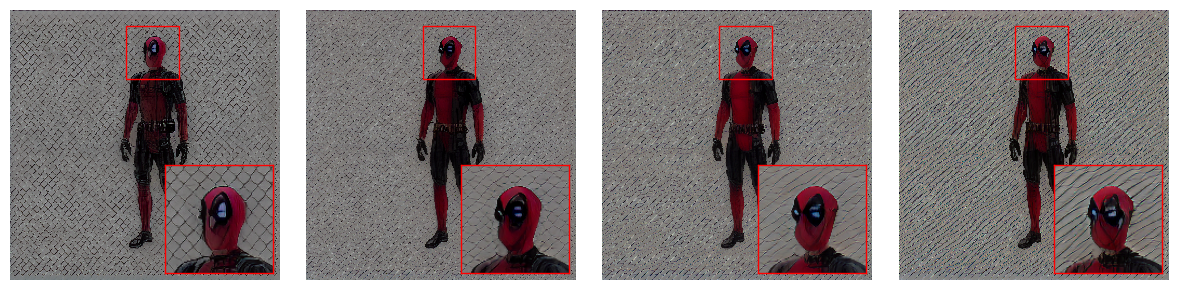

In [8]:
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.matplotlib_utils import add_zoom_inset

row = data[0]

frame_index = 0
frames = [d.frames[frame_index] for d in row]

fig, axs = display_ims(frames, show=False)

for ax in axs:
    box = Bbox.from_bounds(220, 30, 100, 100)
    add_zoom_inset(ax, box)

# plt.savefig('outs/stormtrooper_num_keyframes_quality.pdf', dpi=300, bbox_inches='tight')

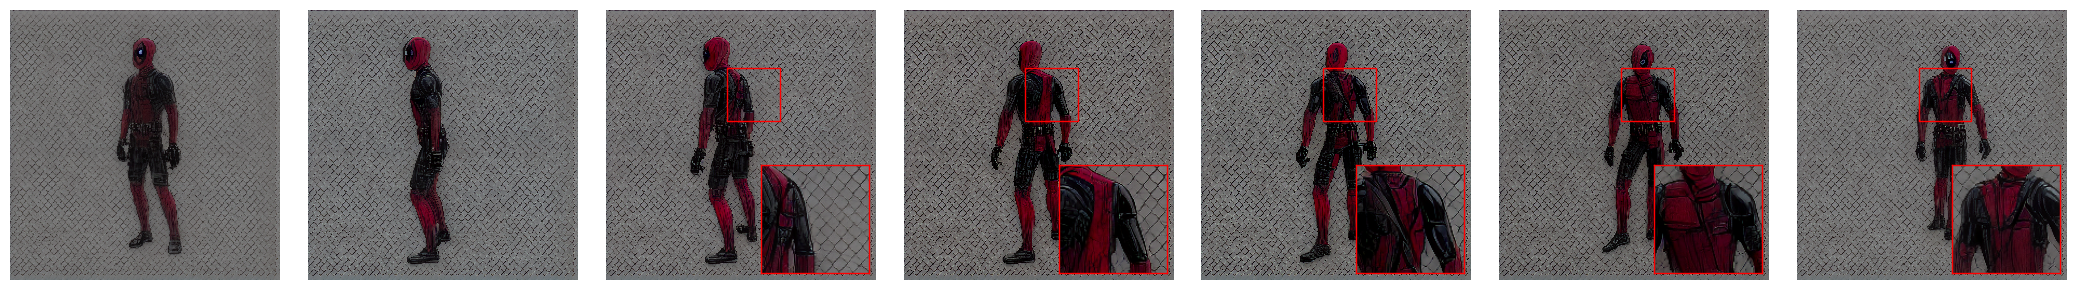

In [9]:
from matplotlib.transforms import Bbox
import numpy as np
from text3d2video.util import ordered_sample_indices
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.matplotlib_utils import add_zoom_inset, bbox_around_point

d = data[0][0]

frame_indices = ordered_sample_indices(d.frames, 7)
frame_indices = [4, 10, 13, 15, 16, 17, 19]
gr_frames = [d.frames[i] for i in frame_indices]

fig, axs = display_ims(gr_frames, show=False)

for i, ax in enumerate(axs):
    center = np.array([280, 160])
    box = bbox_around_point(center, 100)
    if i >= 2:
        add_zoom_inset(ax, box, color='red')

# plt.savefig("outs/180_deadpool_content_drift.pdf", dpi=300, bbox_inches="tight")

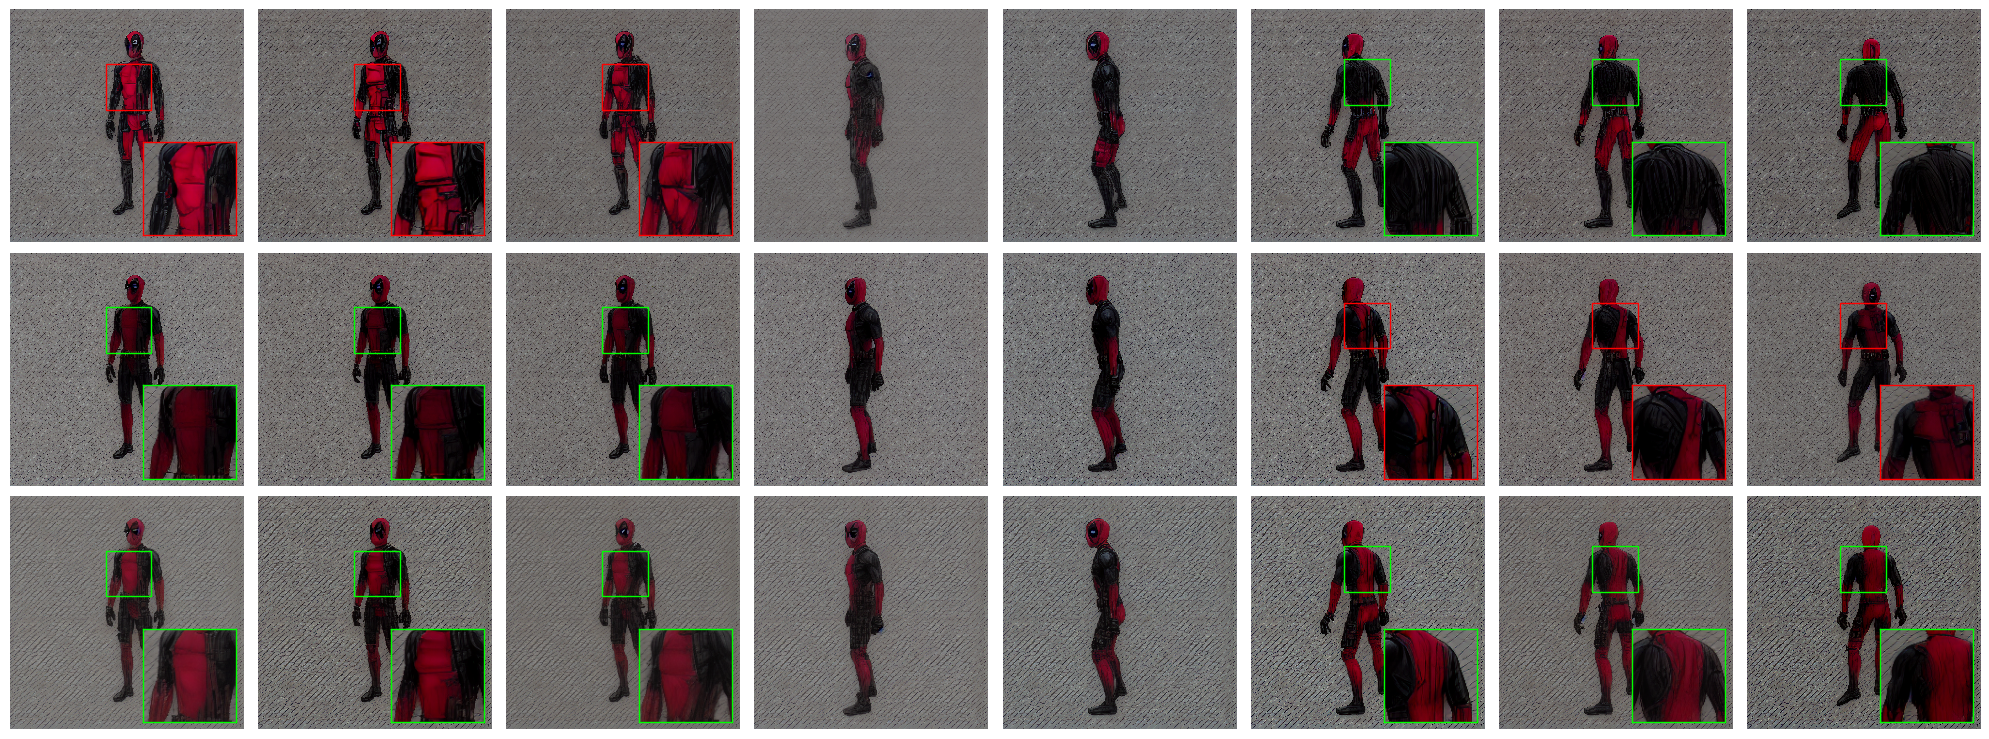

In [68]:
# data[1]

from typing import List
from attr import dataclass
from text3d2video.util import concat_lists
from text3d2video.utilities.ipython_utils import display_ims_grid

kf_runs = [data[2, 0], data[0, 1], data[2, 1]]
r = kf_runs[0]

frame_indices = ordered_sample_indices(r.frames, 8)
frame_indices = torch.arange(len(r.frames)).tolist()


@dataclass
class Inconsistency:
    frame_indices: List[int]
    point: List[float]


inconsistent_frame_indices = [
    Inconsistency([0, 2, 3], [260, 170]),
    Inconsistency([14, 15, 17], [255, 160]),
]
buffer_frame_indices = [8, 10]

frame_indices = sorted(
    concat_lists([i.frame_indices for i in inconsistent_frame_indices])
    + buffer_frame_indices
)

# display frames
frames = [[r.frames[i] for i in frame_indices] for r in kf_runs]
fig, axs = display_ims_grid(frames, show=False)

for i in range(len(frame_indices)):
    frame_i = frame_indices[i]
    col_axs = axs[:, i]

    for row_i, ax in enumerate(col_axs):
        for inconsistency_i, inconsistency in enumerate(inconsistent_frame_indices):
            bbox = bbox_around_point(inconsistency.point, 100)
            if frame_i in inconsistency.frame_indices:
                box_color = "lime"
                if row_i == inconsistency_i:
                    box_color = "red"
                add_zoom_inset(ax, bbox, color=box_color)

plt.savefig(
    "outs/180_deadpool_inconsistency.pdf", dpi=300, bbox_inches="tight"
)

In [18]:
from text3d2video.utilities.video_comparison import display_vids


display_vids(
    [pil_frames_to_clip(r.frames) for r in kf_runs],
)